In [60]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import torch

In [77]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [61]:
torch.cuda.empty_cache()  # Free unused memory

In [62]:
# Directories
train_data_dir = './data/train_data'
test_data_dir = './data/test_data'

In [63]:

import os

def count_files_in_dir(directory):
    class_counts = {}

    # Iterate through subdirectories (classes)
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        # Check if it's a directory (i.e., a class folder)
        if os.path.isdir(subdir_path):
            # Count number of files in the subdirectory
            file_count = len(os.listdir(subdir_path))
            class_counts[subdir] = file_count

    return class_counts

# Count files in train and test directories
train_class_counts = count_files_in_dir(train_data_dir)
test_class_counts = count_files_in_dir(test_data_dir)

# Print counts for train data
print("Train Data Class Counts:")
for class_name, count in train_class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

# Print counts for test data
print("\nTest Data Class Counts:")
for class_name, count in test_class_counts.items():
    print(f"Class: {class_name}, Count: {count}")



Train Data Class Counts:
Class: airport_terminal, Count: 5000
Class: aquarium, Count: 5000
Class: bar, Count: 5000
Class: beach, Count: 5000
Class: music_studio, Count: 5000

Test Data Class Counts:
Class: airport_terminal, Count: 100
Class: aquarium, Count: 100
Class: bar, Count: 100
Class: beach, Count: 100
Class: music_studio, Count: 100


In [64]:
from collections import Counter
from torch.utils.data import Dataset
import glob
import cv2
import torch
from torchvision import transforms
import os

class Scenes(Dataset):
    def __init__(self, folder):
        # Define class folder names
        self.class_folders = ['airport_terminal', 'aquarium', 'beach', 'bar', 'music_studio']

        # Initialize file paths and class labels
        self.fpaths = []
        self.targets = []
        self.target_name = []

        # Loop through each class folder
        for class_name in self.class_folders:
            class_path = os.path.join(folder, class_name, '*.jpg')
            class_files = glob.glob(class_path)

            # Limit to 500 images per class
            #class_files = class_files[:2500]

            # Append file paths and assign class labels
            self.fpaths.extend(class_files)
            self.targets.extend([self.class_folders.index(class_name)] * len(class_files))
            self.target_name.extend(class_name)
        # Shuffle the file paths and corresponding targets
        from random import shuffle, seed
        seed(10)
        combined = list(zip(self.fpaths, self.targets))
        shuffle(combined)
        self.fpaths, self.targets = zip(*combined)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.45, 0.45, 0.45])
    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        #name = self.target_name[ix]
        im = cv2.imread(f)[:, :, ::-1]  # Convert BGR to RGB
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1)  # Reorder dimensions to (channels, height, width)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

    def class_distribution(self):
        # Count the number of images in each class using the targets
        counter = Counter(self.targets)

        # Print the class distribution based on indices in self.class_folders
        for class_idx, class_name in enumerate(self.class_folders):
            print(f"Class: {class_name}, Count: {counter[class_idx]}")


In [65]:
train_data = Scenes(train_data_dir)
train_data.class_distribution()


test_data = Scenes(test_data_dir)
test_data.class_distribution()

Class: airport_terminal, Count: 5000
Class: aquarium, Count: 5000
Class: beach, Count: 5000
Class: bar, Count: 5000
Class: music_studio, Count: 5000
Class: airport_terminal, Count: 100
Class: aquarium, Count: 100
Class: beach, Count: 100
Class: bar, Count: 100
Class: music_studio, Count: 100


In [66]:
print('Train Data: ',len(train_data))
print('Test data:', len(test_data))

Train Data:  25000
Test data: 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0777777..1.32].


tensor([1.], device='cuda:0')


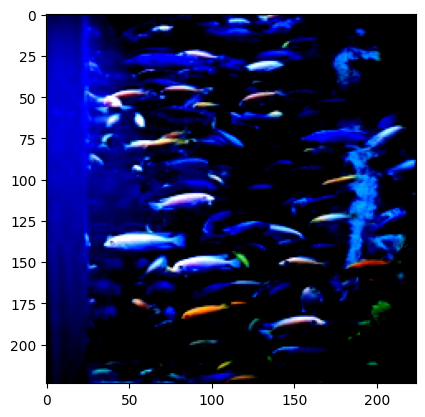

In [67]:
im, label = train_data[400]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0777777..1.2851416].


tensor([4.], device='cuda:0')


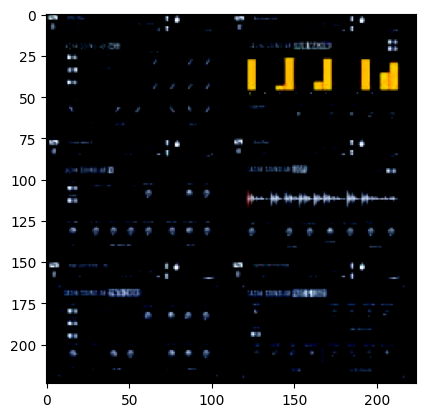

In [68]:
im, label = test_data[100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [69]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def get_model():
    model = models.resnet50(pretrained=True)

    # Freeze the parameters in the feature extractor layers
    for param in model.parameters():
        param.requires_grad = False

    # Update the average pooling layer
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    # Update the fully connected layer (classification head)
    # The input to the Linear layer should be 2048, not 512
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        #nn.Linear(1024, 512),
        #nn.ReLU(),
        #nn.Dropout(0.2),
        #nn.Linear(512, 256),
        #nn.ReLU(),
        #nn.Dropout(0.2),
        nn.Linear(512, 128),
        nn.ReLU(),
        #nn.Dropout(0.2),
        nn.Linear(128, 5)
    )

    # Multi-class Cross Entropy Loss
    loss_fn = nn.CrossEntropyLoss()

    # Adam optimizer (optimized for the new layers only)
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-2)  # Only optimize the new fully connected layers

    return model.to(device), loss_fn, optimizer
'''

'\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torchvision import models\n\ndef get_model():\n    model = models.resnet50(pretrained=True)\n\n    # Freeze the parameters in the feature extractor layers\n    for param in model.parameters():\n        param.requires_grad = False\n\n    # Update the average pooling layer\n    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))\n\n    # Update the fully connected layer (classification head)\n    # The input to the Linear layer should be 2048, not 512\n    model.fc = nn.Sequential(\n        nn.Flatten(),\n        nn.Linear(2048, 512),\n        nn.ReLU(),\n        nn.Dropout(0.2),\n        #nn.Linear(1024, 512),\n        #nn.ReLU(),\n        #nn.Dropout(0.2),\n        #nn.Linear(512, 256),\n        #nn.ReLU(),\n        #nn.Dropout(0.2),\n        nn.Linear(512, 128),\n        nn.ReLU(),\n        #nn.Dropout(0.2),\n        nn.Linear(128, 5)\n    )\n\n    # Multi-class Cross Entropy Loss\n    loss_fn = nn.CrossEnt

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_model():
    model = models.resnet50(pretrained=True)

    # Freeze the parameters in the feature extractor layers
    for param in model.parameters():
        param.requires_grad = False

    # Move the average pooling layer to the CPU
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1)).cpu()

    # Move the fully connected layer (classification head) to the CPU
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 5)
    ).cpu()

    # Move only the feature extractor part of the model to the GPU
    model = model.to(device)

    # Multi-class Cross Entropy Loss
    loss_fn = nn.CrossEntropyLoss()

    # Adam optimizer (optimized for the new layers only)
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-2)  # Only optimize the new fully connected layers

    return model, loss_fn, optimizer

In [71]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [72]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    #print(prediction.shape)
    #print(y.shape)
    #print(prediction)
    #print(y)
    #probs = torch.softmax(prediction, dim=1)
    #predicted_labels = torch.argmax(probs, dim=1)
    #print(predicted_labels)
    #print(y)
    batch_loss = loss_fn(prediction , y.squeeze(1).long())
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [73]:
'''
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()
'''

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    logits = model(x)
    probs = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probs, dim=1)
    is_correct = (predicted_labels == y).float()
    return is_correct.cpu().numpy().tolist()

In [74]:
def get_data():
    train = Scenes(train_data_dir)
    trn_dl = DataLoader(train, batch_size=512, shuffle=True, drop_last = True)
    val = Scenes(test_data_dir)
    val_dl = DataLoader(val, batch_size=50, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [75]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [76]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(10):
    print(f" epoch {epoch + 1}/10")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(train_epoch_loss)

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(train_epoch_accuracy)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/10


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 6.82 GiB is allocated by PyTorch, and 1.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [40]:
print(val_accuracies)

[np.float64(0.222265625), np.float64(0.2259765625), np.float64(0.21979166666666666), np.float64(0.22337239583333332), np.float64(0.22330729166666666), np.float64(0.21861979166666667), np.float64(0.21451822916666666), np.float64(0.22317708333333333), np.float64(0.22109375), np.float64(0.21985677083333333)]


In [58]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4933 MiB |   7294 MiB |  55096 GiB |  55091 GiB |
|       from large pool |   4861 MiB |   7222 MiB |  54779 GiB |  54774 GiB |
|       from small pool |     71 MiB |    662 MiB |    316 GiB |    316 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4933 MiB |   7294 MiB |  55096 GiB |  55091 GiB |
|       from large pool |   4861 MiB |   7222 MiB |  54779 GiB |

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_22316\3763125138.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


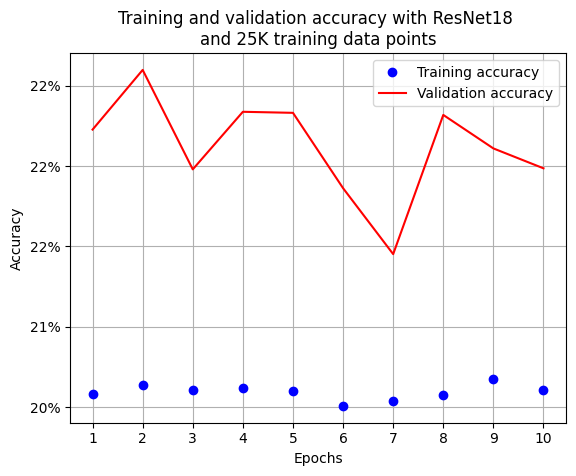

In [42]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 25K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()